# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_context("notebook")

In [16]:
columns = ['x1', 'x2', 'x3', 'x4', 'y']
df = pd.read_csv('../data/lin_reg.txt', header=None, names=columns)
x_cols = columns[:4]
df[x_cols] = (df[x_cols] - np.mean(df[x_cols])) / np.std(df[x_cols])

X = df[x_cols].values
Y = df['y'].values

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

## 1

In [13]:
from scipy.optimize import minimize


def MSE(pred, test):
    return np.mean((pred - test) ** 2)


class LinearRegression:
    def __init__(self, alpha=0, lr=0.01, max_iter=1000):
        self.a = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.history = {
            "w": [],
            "error": [],
        }
        self.w0 = None

    @staticmethod
    def Q(w0, X, y, a=0):
        return np.mean((X @ w0 - y) ** 2) + a * (np.sum(w0 ** 2))

    def fit(self, X, y):
        def callback(w):
            self.history["w"].append(w)
            self.history["error"].append(MSE(X @ w, y))

        self.w0 = np.zeros(X.shape[1])
        self.w0 = minimize(self.Q, self.w0, args=(X, y, a), callback=callback).x

    def predict(self, x):
        return x @ self.w0


In [17]:
scores = []
for a in np.linspace(0, 1, 100):
    model = LinearRegression(alpha=a)
    model.fit(X, Y)
    scores.append(MSE(X @ model.w0, Y))


Text(0, 0.5, 'MSE')

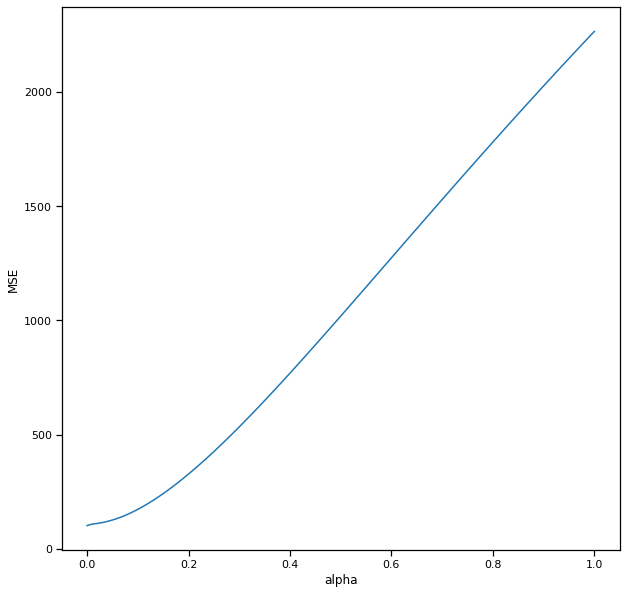

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(np.linspace(0, 1, 100), scores)
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")


## 2

In [29]:
def cross_validation(X, y, cv=5, a=0):
    n = X.shape[0]
    num_test_samples = n // cv
    history = {
        'train_error': [],
        'test_error': []
    }
    for fold_edge in range(num_test_samples, n + num_test_samples, num_test_samples):
        X_train = np.vstack((X[:n - fold_edge], X[n + num_test_samples - fold_edge - 1:]))
        y_train = np.append(y[:n - fold_edge], y[n + num_test_samples - fold_edge - 1:])
        X_test = X[n - fold_edge : n + num_test_samples - fold_edge - 1]
        y_test = y[n - fold_edge : n + num_test_samples - fold_edge - 1]
        model = LinearRegression(alpha=a)
        model.fit(X_train, y_train)

        history['train_error'].append(MSE(X_train @ model.w0, y_train))
        history['test_error'].append(MSE(X_test @ model.w0, y_test))
    history['train_error'] = np.array(history['train_error'])
    history['test_error'] = np.array(history['test_error'])
    return history


## 3

In [42]:
mean_errors = []
alphas = np.linspace(0, 1, 200)
for a in alphas:
    history_cv = cross_validation(X, Y, a=a)  
    mean_errors.append(history_cv['test_error'].mean())
mean_errors = np.array(mean_errors)

In [44]:

min_val = min(mean_errors)
optimal_a = alphas[mean_errors == min_val][0]
print(f'Оптимальное a={optimal_a}, MSE при этом {min_val}')

Оптимальное a=0.0, MSE при этом 102.68254769579578


## 4 

In [45]:

def plot_validation_curve(alphas, scores):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(alphas, scores)
    ax.set_xlabel("alpha")
    ax.set_ylabel("score")


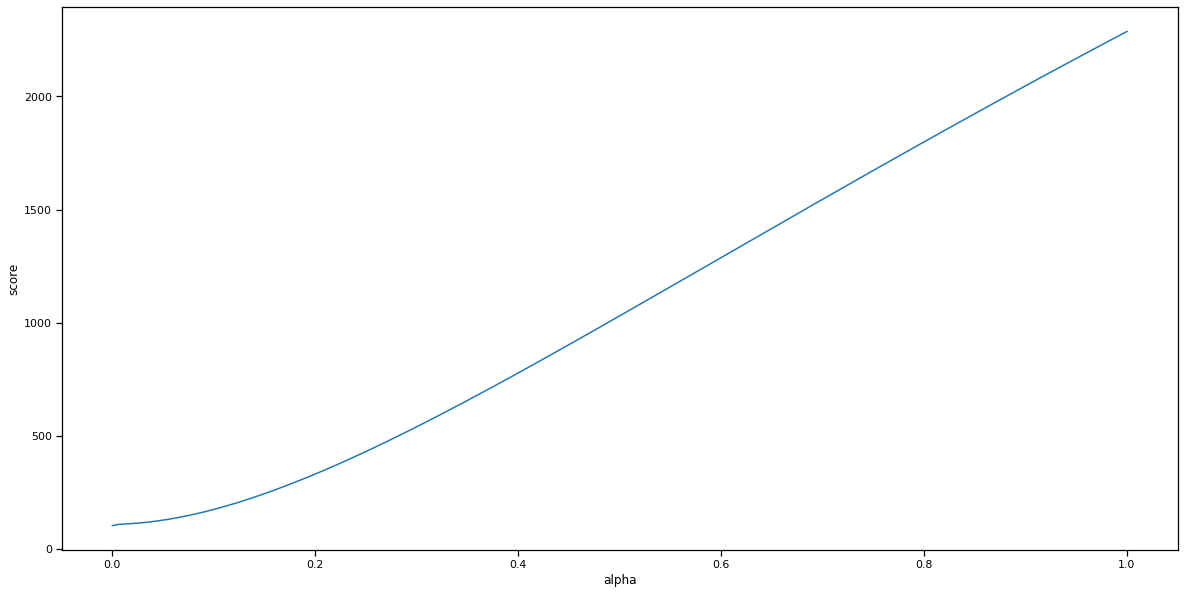

In [47]:
plot_validation_curve(alphas, mean_errors)

## 5 Learning curve

In [50]:
def plot_learning_curve(history, X_test, Y_test):
    val_score = []
    for w in history['w']:
        val_score.append(MSE(X_test @ w, Y_test))
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    ax.plot(history['error'])
    ax.plot(val_score)
    
    plt.legend(['train', 'test'])
    plt.title('Learning curve')

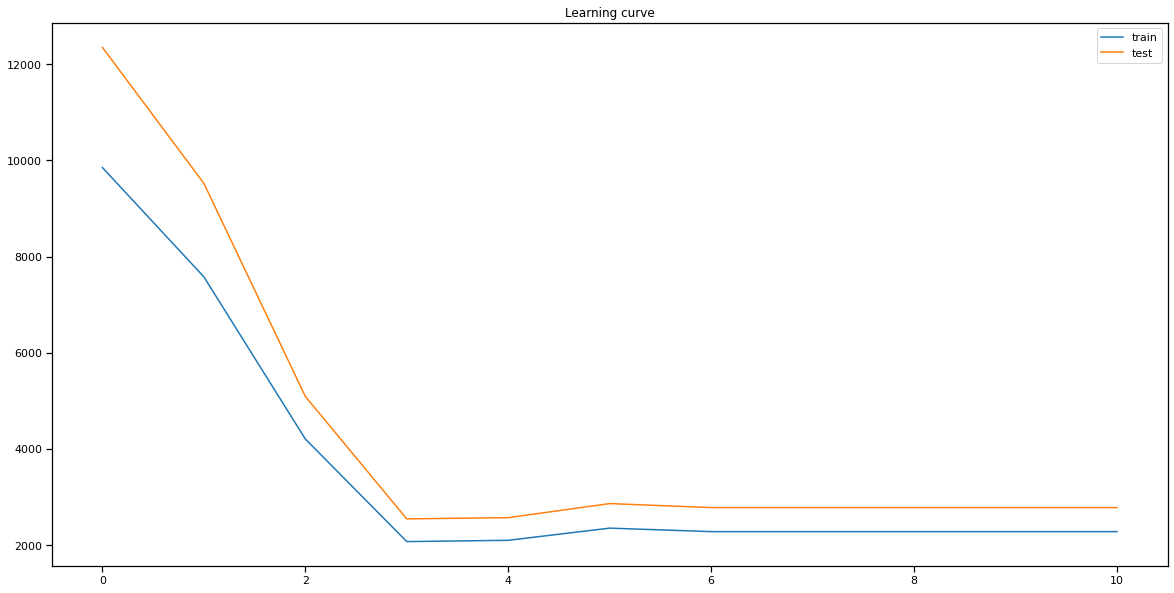

In [51]:
n = X.shape[0]
splitter = int(n * 0.8)
X_train = X[:splitter]
y_train = Y[:splitter]
X_test = X[splitter:]
y_test = Y[splitter:]
model = LinearRegression(alpha=optimal_a)
model.fit(X_train, y_train)
plot_learning_curve(model.history, X_test, y_test)